This notebook is created using the following article: https://medium.com/analytics-vidhya/time-series-forecasting-a-complete-guide-d963142da33f

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import math
from scipy.stats import variation

import sklearn
from sklearn.metrics import mean_squared_error

%matplotlib inline
warnings.filterwarnings('ignore')
sns.set_style("darkgrid")

In [4]:
df_train = pd.read_csv(r'./data/train.csv')
display(df_train.head())
print(df_train.shape)

,date,store,item,sales
0,2013-01-01,1,1,13
1,2013-01-02,1,1,11
2,2013-01-03,1,1,14
3,2013-01-04,1,1,13
4,2013-01-05,1,1,10


(913000, 4)


In [7]:
df_test = pd.read_csv(r'./data/test.csv', usecols={'date', 'store', 'item'})
display(df_test.head())
print(df_test.shape)

,date,store,item
0,2018-01-01,1,1
1,2018-01-02,1,1
2,2018-01-03,1,1
3,2018-01-04,1,1
4,2018-01-05,1,1


(45000, 3)


# EDA

In [9]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 913000 entries, 0 to 912999
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   date    913000 non-null  object
 1   store   913000 non-null  int64 
 2   item    913000 non-null  int64 
 3   sales   913000 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 27.9+ MB


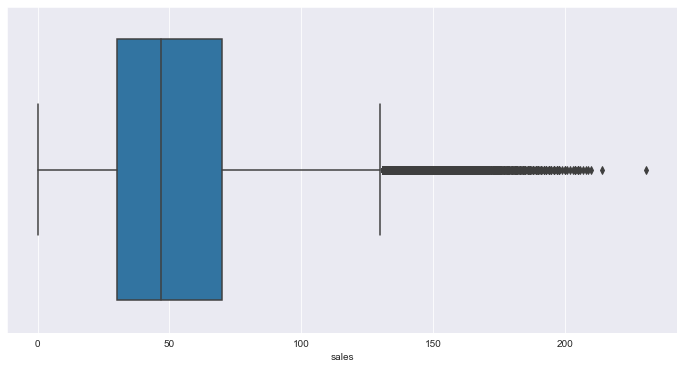

In [12]:
plt.figure(figsize=(12,6))
sns.boxplot(df_train['sales'])
plt.show()

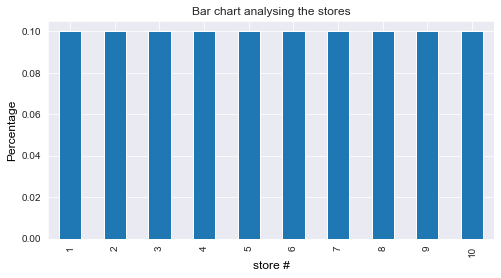

In [16]:
plt.figure(figsize= (8,4))
df_train["store"].value_counts(normalize=True).plot.bar()
plt.title("Bar chart analysing the stores",)
plt.xlabel("store #", fontdict={'fontsize': 12, 'fontweight' : 5, 'color' : 'Black'})
plt.ylabel("Percentage", fontdict={'fontsize': 12, 'fontweight' : 5, 'color' : 'Black'} )
plt.show()

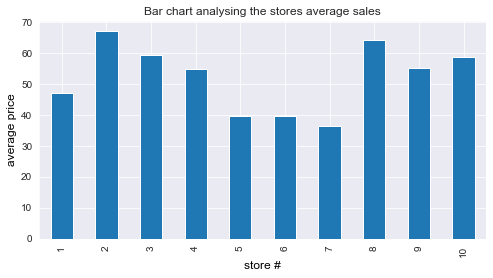

In [17]:
plt.figure(figsize= (8,4))
df_train.groupby(["store"])['sales'].mean().plot.bar()
plt.title("Bar chart analysing the stores average sales",)
plt.xlabel("store #", fontdict={'fontsize': 12, 'fontweight' : 5, 'color' : 'Black'})
plt.ylabel("average price", fontdict={'fontsize': 12, 'fontweight' : 5, 'color' : 'Black'} )
plt.show()

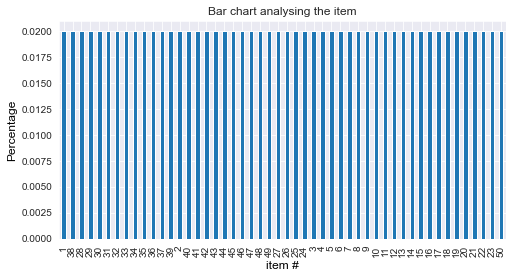

In [18]:
plt.figure(figsize= (8,4))
df_train["item"].value_counts(normalize=True).plot.bar()
plt.title("Bar chart analysing the item",)
plt.xlabel("item #", fontdict={'fontsize': 12, 'fontweight' : 5, 'color' : 'Black'})
plt.ylabel("Percentage", fontdict={'fontsize': 12, 'fontweight' : 5, 'color' : 'Black'} )
plt.show()

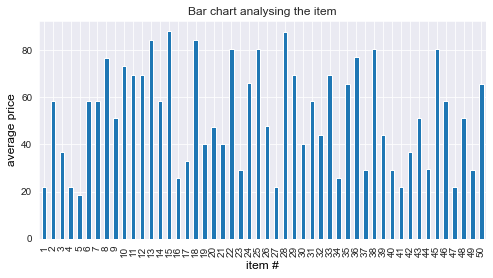

In [20]:
plt.figure(figsize= (8,4))
df_train.groupby(["item"])['sales'].mean().plot.bar()
plt.title("Bar chart analysing the item",)
plt.xlabel("item #", fontdict={'fontsize': 12, 'fontweight' : 5, 'color' : 'Black'})
plt.ylabel("average price", fontdict={'fontsize': 12, 'fontweight' : 5, 'color' : 'Black'} )
plt.show()

In [23]:
# plt.figure(figsize=(15,8))
# sns.barplot(data=df_train, x='store', y= 'sales', hue='item')
# plt.title('Bar chart analysing Sales for different Store-Item\n', fontdict={'fontsize': 16})
# # plt.legend(loc = 'best')
# plt.show()

# Data Prep

In [25]:
df_train['store_item'] = df_train['store'].map(str)+'-'+df_train['item'].map(str)

In [26]:
df_train['year_month'] = pd.to_datetime(df_train['date']).dt.to_period('m') 

In [27]:
df_train.head()

,date,store,item,sales,store_item,year_month
0,2013-01-01,1,1,13,1-1,2013-01
1,2013-01-02,1,1,11,1-1,2013-01
2,2013-01-03,1,1,14,1-1,2013-01
3,2013-01-04,1,1,13,1-1,2013-01
4,2013-01-05,1,1,10,1-1,2013-01


In [34]:
df_train.groupby(['store_item', 'year_month'])['sales'].sum().reset_index().head()

,store_item,year_month,sales
0,1-1,2013-01,328
1,1-1,2013-02,322
2,1-1,2013-03,477
3,1-1,2013-04,522
4,1-1,2013-05,531


In [36]:
df_train.year_month.nunique()

60

In [33]:
data_cov = pd.pivot_table(data = df_train, index = "year_month", columns = "store_item", values = "sales", aggfunc="sum")
data_cov.head()

store_item,1-1,1-10,1-11,1-12,1-13,1-14,1-15,1-16,1-17,1-18,...,9-46,9-47,9-48,9-49,9-5,9-50,9-6,9-7,9-8,9-9
year_month,,,,,,,,,,,,,,,,,,,,,
2013-01,328,1121,1093,1128,1308,906,1354,382,561,1336,...,1092,404,903,509,343,1209,1061,1030,1391,957
2013-02,322,1132,1158,1080,1341,991,1383,409,519,1330,...,1078,430,979,580,342,1194,1072,1080,1417,997
2013-03,477,1599,1488,1490,1858,1219,1843,524,730,1738,...,1487,598,1302,731,473,1659,1400,1460,1838,1264
2013-04,522,1717,1694,1613,1894,1385,2099,640,781,2013,...,1639,593,1441,812,481,1791,1610,1643,2127,1360
2013-05,531,1825,1851,1822,2244,1540,2360,722,854,2323,...,1847,640,1573,871,577,1964,1691,1756,2326,1576


In [38]:
train_len = 54
train = data_cov[0 : train_len]
test = data_cov[train_len : ]

print(train.shape)
print(test.shape)

(54, 500)
(6, 500)


In [39]:
train_mean = np.mean(train)
train_mean

store_item
1-1      596.370370
1-10    1974.870370
1-11    1880.907407
1-12    1883.444444
1-13    2270.740741
           ...     
9-50    2067.555556
9-6     1830.037037
9-7     1844.759259
9-8     2421.833333
9-9     1616.166667
Length: 500, dtype: float64

In [40]:
train_std = np.std(train)
train_std

store_item
1-1     136.356327
1-10    419.584276
1-11    394.433268
1-12    413.064638
1-13    485.525114
           ...    
9-50    446.929925
9-6     390.116030
9-7     402.200196
9-8     531.963545
9-9     346.156663
Length: 500, dtype: float64

In [41]:
train_CoV = train_std/train_mean
train_CoV

store_item
1-1     0.228644
1-10    0.212462
1-11    0.209704
1-12    0.219313
1-13    0.213818
          ...   
9-50    0.216163
9-6     0.213174
9-7     0.218023
9-8     0.219653
9-9     0.214184
Length: 500, dtype: float64

In [43]:
CoV = pd.DataFrame({'Mean' : train_mean, 'Std_Dev' : train_std, 'Coeff_of_Var' : train_CoV})
CoV.sort_values('Coeff_of_Var')

,Mean,Std_Dev,Coeff_of_Var
store_item,,,
2-34,983.333333,202.684484,0.206120
2-41,834.277778,172.426196,0.206677
6-2,1326.055556,274.175560,0.206760
8-4,804.037037,166.683217,0.207308
5-37,665.074074,137.934345,0.207397
...,...,...,...
5-27,499.962963,113.774788,0.227566
5-41,502.611111,114.905826,0.228618
1-1,596.370370,136.356327,0.228644


In [44]:
data_2_34 = df_train[df_train['store_item'] == '2-34']
data_2_34.head()

,date,store,item,sales,store_item,year_month
604406,2013-01-01,2,34,18,2-34,2013-01
604407,2013-01-02,2,34,20,2-34,2013-01
604408,2013-01-03,2,34,23,2-34,2013-01
604409,2013-01-04,2,34,14,2-34,2013-01
604410,2013-01-05,2,34,18,2-34,2013-01


In [73]:
data1 = data_2_34.groupby(['year_month'])['sales'].sum()#.reset_index()
data1 = pd.DataFrame(data1)
data1.index = data1.index.to_timestamp()

In [74]:
data1.index.dtype

dtype('<M8[ns]')

In [57]:
data1.year_month = data1.year_month.astype('str')

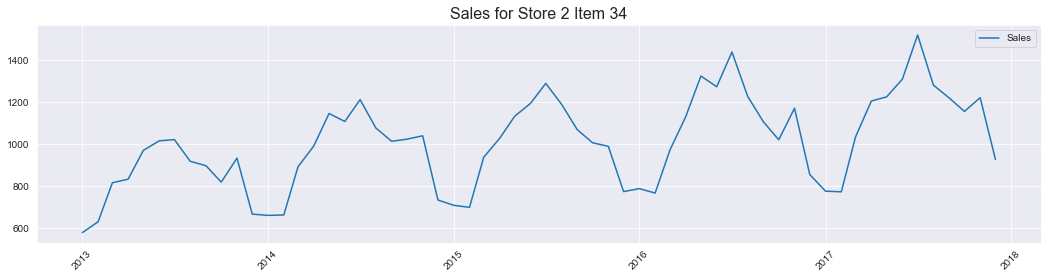

In [76]:
plt.figure(figsize=(18,4))
plt.plot(data1['sales'],label='Sales')
# plt.plot(data1[0 : train_len]['year_month'], data1[0 : train_len]['sales'],label='train')
# plt.plot(data1[train_len : ]['year_month'], data1[train_len : ]['sales'],label='test')
plt.legend(loc='best')
plt.title('Sales for Store 2 Item 34', fontdict={'fontsize': 16, 'fontweight' : 5, })
plt.xticks(rotation = 45,)
plt.show()

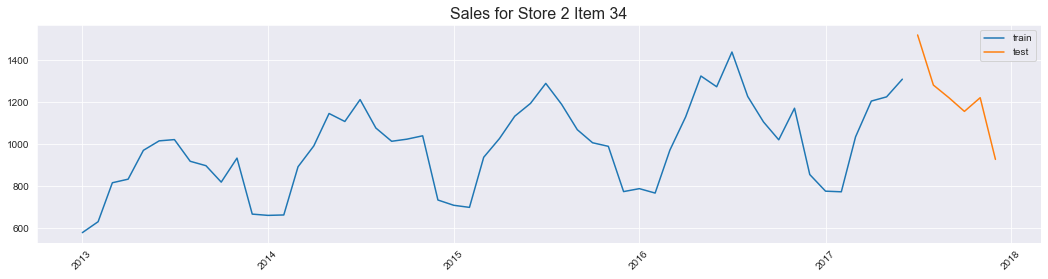

In [77]:
plt.figure(figsize=(18,4))
# plt.plot(data1['year_month'], data1['sales'],label='Sales')
plt.plot(data1[0 : train_len]['sales'],label='train')
plt.plot(data1[train_len : ]['sales'],label='test')
plt.legend(loc='best')
plt.title('Sales for Store 2 Item 34', fontdict={'fontsize': 16, 'fontweight' : 5, })
plt.xticks(rotation = 45,)
plt.show()

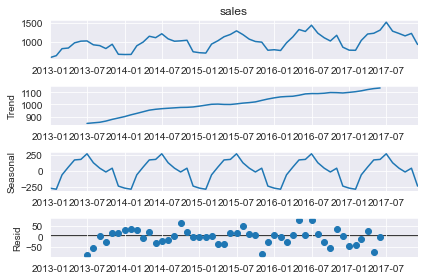

In [84]:
# from pylab import rcParams
import statsmodels.api as sm
# rcParams['figure.figsize'] = 12, 8
decomposition = sm.tsa.seasonal_decompose(data1.sales, model='additive') # additive seasonal index
fig = decomposition.plot()
plt.show()

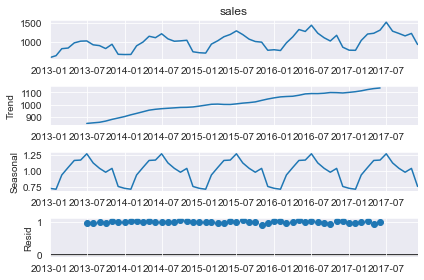

In [86]:
decomposition = sm.tsa.seasonal_decompose(data1.sales, model='multiplicative') # multiplicative seasonal index
fig = decomposition.plot()
plt.show()

This data is seasonal.

In [87]:
train = data1[0 : train_len]
test = data1[train_len : ]

# Modeling

## Navie Method

In [89]:
y_hat_naive = test.copy()
y_hat_naive['naive_forecast'] = train['sales'][train_len-1]

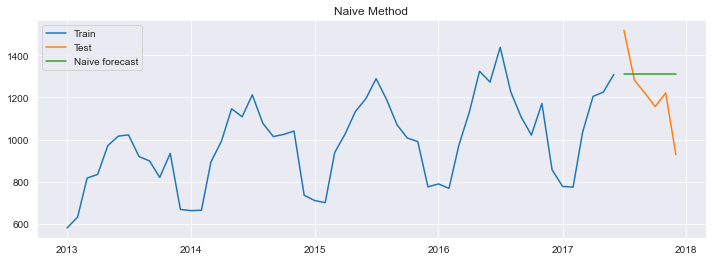

In [90]:
plt.figure(figsize=(12,4))
plt.plot(train['sales'], label='Train')
plt.plot(test['sales'], label='Test')
plt.plot(y_hat_naive['naive_forecast'], label='Naive forecast')
plt.legend(loc='best')
plt.title('Naive Method')
plt.show()

In [92]:
rmse = np.sqrt(mean_squared_error(test['sales'], y_hat_naive['naive_forecast'])).round(2)
mape = np.round(np.mean(np.abs(test['sales']-y_hat_naive['naive_forecast'])/test['sales'])*100,2)

results = pd.DataFrame({'Method':['Naive method'], 'MAPE': [mape], 'RMSE': [rmse]})
results = results[['Method', 'RMSE', 'MAPE']]
results

,Method,RMSE,MAPE
0,Naive method,195.41,14.13


## Simple Average Method

In [93]:
y_hat_avg = test.copy()
y_hat_avg['avg_forecast'] = train['sales'].mean()

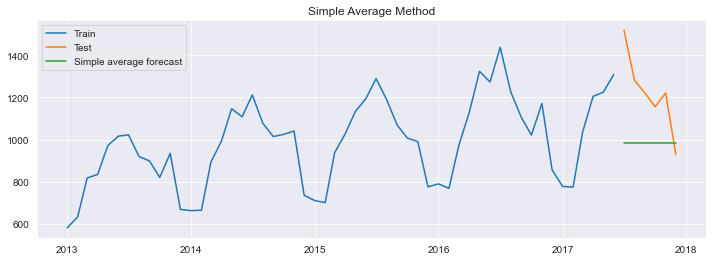

In [96]:
plt.figure(figsize=(12,4))
plt.plot(train['sales'], label='Train')
plt.plot(test['sales'], label='Test')
plt.plot(y_hat_avg['avg_forecast'], label='Simple average forecast')
plt.legend(loc='best')
plt.title('Simple Average Method')
plt.show()

In [97]:
rmse = np.sqrt(mean_squared_error(test['sales'], y_hat_avg['avg_forecast'])).round(2)
mape = np.round(np.mean(np.abs(test['sales']-y_hat_avg['avg_forecast'])/test['sales'])*100,2)

tempResults = pd.DataFrame({'Method':['Simple average method'], 'RMSE': [rmse],'MAPE': [mape] })
results = pd.concat([results, tempResults])
results = results[['Method', 'RMSE', 'MAPE']]
results

,Method,RMSE,MAPE
0,Naive method,195.41,14.13
0,Simple average method,294.65,19.71


## Simple moving average method

In [98]:
y_hat_sma = data1.copy()
ma_window = 12
y_hat_sma['sma_forecast'] = data1['sales'].rolling(ma_window).mean()
y_hat_sma['sma_forecast'][train_len:] = y_hat_sma['sma_forecast'][train_len-1]

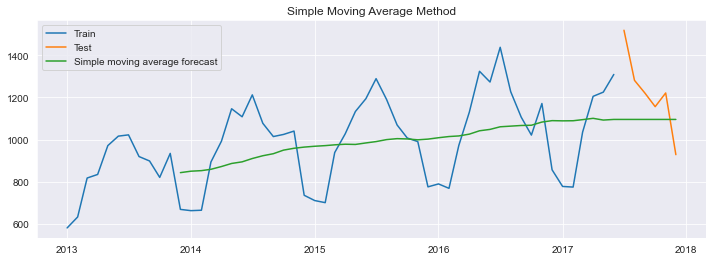

In [99]:
plt.figure(figsize=(12,4))
plt.plot(train['sales'], label='Train')
plt.plot(test['sales'], label='Test')
plt.plot(y_hat_sma['sma_forecast'], label='Simple moving average forecast')
plt.legend(loc='best')
plt.title('Simple Moving Average Method')
plt.show()

In [102]:
rmse = np.sqrt(mean_squared_error(test['sales'], y_hat_sma['sma_forecast'][train_len:])).round(2)
mape = np.round(np.mean(np.abs(test['sales']-y_hat_sma['sma_forecast'][train_len:])/test['sales'])*100,2)

tempResults = pd.DataFrame({'Method':['Simple moving average forecast'], 'RMSE': [rmse],'MAPE': [mape] })
results = pd.concat([results, tempResults])
results = results[['Method', 'RMSE', 'MAPE']]
results

,Method,RMSE,MAPE
0,Naive method,195.41,14.13
0,Simple average method,294.65,19.71
0,Simple moving average forecast,214.86,14.36


## Exponential Smoothing Techniques


### Simple exponential smoothing


In [103]:
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
model = SimpleExpSmoothing(train['sales'])
model_fit = model.fit(optimized=True)
model_fit.params
y_hat_ses = test.copy()
y_hat_ses['ses_forecast'] = model_fit.forecast(len(test))

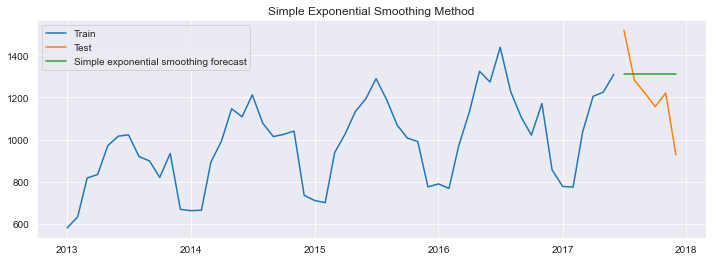

In [104]:
plt.figure(figsize=(12,4))
plt.plot(train['sales'], label='Train')
plt.plot(test['sales'], label='Test')
plt.plot(y_hat_ses['ses_forecast'], label='Simple exponential smoothing forecast')
plt.legend(loc='best')
plt.title('Simple Exponential Smoothing Method')
plt.show()

In [106]:
rmse = np.sqrt(mean_squared_error(test['sales'], y_hat_ses['ses_forecast'])).round(2)
mape = np.round(np.mean(np.abs(test['sales']-y_hat_ses['ses_forecast'])/test['sales'])*100,2)

tempResults = pd.DataFrame({'Method':['Simple exponential smoothing forecast'], 'RMSE': [rmse],'MAPE': [mape] })
results = pd.concat([results, tempResults])
results

,Method,RMSE,MAPE
0,Naive method,195.41,14.13
0,Simple average method,294.65,19.71
0,Simple moving average forecast,214.86,14.36
0,Simple exponential smoothing forecast,195.41,14.13


Comment: This is surprising because the exponential smoothing produces the same result as the naive method. 

### Holt's method with trend

In [107]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing
model = ExponentialSmoothing(np.asarray(train['sales']) ,seasonal_periods=12 ,trend='additive', seasonal=None)
model_fit = model.fit(optimized=True)
print(model_fit.params)
y_hat_holt = test.copy()
y_hat_holt['holt_forecast'] = model_fit.forecast(len(test))

{'smoothing_level': 0.9777614367065218, 'smoothing_trend': 0.022876703203110253, 'smoothing_seasonal': nan, 'damping_trend': nan, 'initial_level': 578.2267128186894, 'initial_trend': 14.859081100329435, 'initial_seasons': array([], dtype=float64), 'use_boxcox': False, 'lamda': None, 'remove_bias': False}


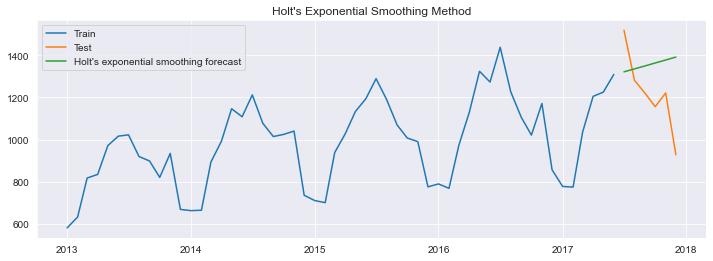

In [108]:
plt.figure(figsize=(12,4))
plt.plot( train['sales'], label='Train')
plt.plot(test['sales'], label='Test')
plt.plot(y_hat_holt['holt_forecast'], label='Holt\'s exponential smoothing forecast')
plt.legend(loc='best')
plt.title('Holt\'s Exponential Smoothing Method')
plt.show()

In [110]:
rmse = np.sqrt(mean_squared_error(test['sales'], y_hat_holt['holt_forecast'])).round(2)
mape = np.round(np.mean(np.abs(test['sales']-y_hat_holt['holt_forecast'])/test['sales'])*100,2)

tempResults = pd.DataFrame({'Method':['Holt\'s exponential smoothing method'], 'RMSE': [rmse],'MAPE': [mape] })
results = pd.concat([results, tempResults])
results = results[['Method', 'RMSE', 'MAPE']]
results

,Method,RMSE,MAPE
0,Naive method,195.41,14.13
0,Simple average method,294.65,19.71
0,Simple moving average forecast,214.86,14.36
0,Simple exponential smoothing forecast,195.41,14.13
0,Holt's exponential smoothing method,238.50,18.10


### Holt Winters' additive method with trend and seasonality


In [111]:
y_hat_hwa = test.copy()
model = ExponentialSmoothing(np.asarray(train['sales']) ,seasonal_periods=12 ,trend='add', seasonal='add')
model_fit = model.fit(optimized=True)
print(model_fit.params)
y_hat_hwa['hw_forecast'] = model_fit.forecast(len(test))

{'smoothing_level': 0.4646519811232161, 'smoothing_trend': 0.00020877135353560033, 'smoothing_seasonal': 2.4119537920240422e-05, 'damping_trend': nan, 'initial_level': 708.6838948452892, 'initial_trend': 4.886954029750755, 'initial_seasons': array([-131.21907475, -132.31236857,   86.42089023,  188.20990775,
        305.36449643,  320.40325145,  404.02872017,  262.3206469 ,
        175.97670564,  117.38548093,  177.98522117, -101.70452628]), 'use_boxcox': False, 'lamda': None, 'remove_bias': False}


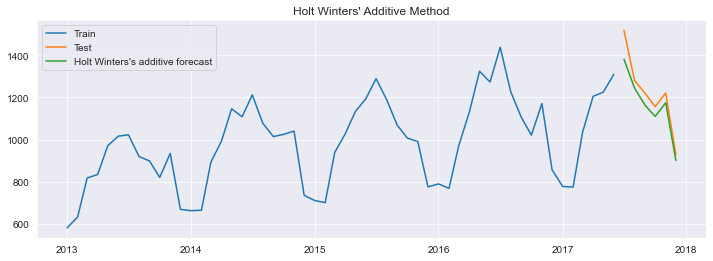

In [112]:
plt.figure(figsize=(12,4))
plt.plot( train['sales'], label='Train')
plt.plot(test['sales'], label='Test')
plt.plot(y_hat_hwa['hw_forecast'], label='Holt Winters\'s additive forecast')
plt.legend(loc='best')
plt.title('Holt Winters\' Additive Method')
plt.show()

In [113]:
rmse = np.sqrt(mean_squared_error(test['sales'], y_hat_hwa['hw_forecast'])).round(2)
mape = np.round(np.mean(np.abs(test['sales']-y_hat_hwa['hw_forecast'])/test['sales'])*100,2)

tempResults = pd.DataFrame({'Method':['Holt Winters\' additive method'], 'RMSE': [rmse],'MAPE': [mape] })
results = pd.concat([results, tempResults])
results = results[['Method', 'RMSE', 'MAPE']]
results

,Method,RMSE,MAPE
0,Naive method,195.41,14.13
0,Simple average method,294.65,19.71
0,Simple moving average forecast,214.86,14.36
0,Simple exponential smoothing forecast,195.41,14.13
0,Holt's exponential smoothing method,238.50,18.10
0,Holt Winters' additive method,68.99,4.56


Note: The additive method has the most accuracy for this data.

### Holt Winter's multiplicative method with trend and seasonality


In [114]:
y_hat_hwm = test.copy()
model = ExponentialSmoothing(np.asarray(train['sales']) ,seasonal_periods=12 ,trend='add', seasonal='mul')
model_fit = model.fit(optimized=True)
print(model_fit.params)
y_hat_hwm['hw_forecast'] = model_fit.forecast(len(test))

{'smoothing_level': 0.25517530530952615, 'smoothing_trend': 8.413010988298562e-09, 'smoothing_seasonal': 1.3127389940780827e-07, 'damping_trend': nan, 'initial_level': 600.2273866010669, 'initial_trend': 4.195627758312, 'initial_seasons': array([0.97012095, 0.9676504 , 1.26651652, 1.40923295, 1.56149854,
       1.58044472, 1.70508378, 1.50649524, 1.38326624, 1.30392206,
       1.38397681, 1.01171632]), 'use_boxcox': False, 'lamda': None, 'remove_bias': False}


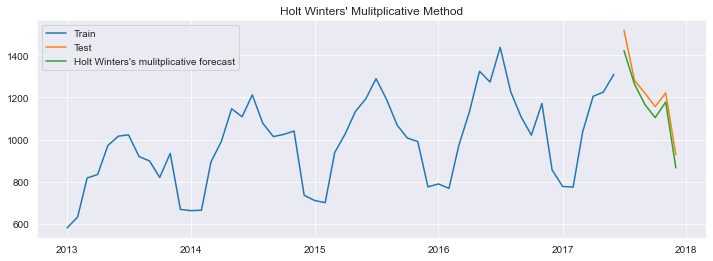

In [115]:
plt.figure(figsize=(12,4))
plt.plot( train['sales'], label='Train')
plt.plot(test['sales'], label='Test')
plt.plot(y_hat_hwm['hw_forecast'], label='Holt Winters\'s mulitplicative forecast')
plt.legend(loc='best')
plt.title('Holt Winters\' Mulitplicative Method')
plt.show()

In [117]:
# Calculate RMSE and MAPE

rmse = np.sqrt(mean_squared_error(test['sales'], y_hat_hwm['hw_forecast'])).round(2)
mape = np.round(np.mean(np.abs(test['sales']-y_hat_hwm['hw_forecast'])/test['sales'])*100,2)

tempResults = pd.DataFrame({'Method':['Holt Winters\' multiplicative method'], 'RMSE': [rmse],'MAPE': [mape] })
results = pd.concat([results, tempResults])
results = results[['Method', 'RMSE', 'MAPE']]
results

,Method,RMSE,MAPE
0,Naive method,195.41,14.13
0,Simple average method,294.65,19.71
0,Simple moving average forecast,214.86,14.36
0,Simple exponential smoothing forecast,195.41,14.13
0,Holt's exponential smoothing method,238.50,18.10
0,Holt Winters' additive method,68.99,4.56
0,Holt Winters' multiplicative method,59.51,4.52


Comment: The results are fairly similar for for the last two models when comparing the MAPE, but the RMSE has a stark difference. 

**For this data, the Multiplicative method is the the best to explain the trend and seasonality in the data.**

## Auto Regressive methods


### Check whether the time series is stationary

#### Augmented Dickey-Fuller (ADF) test

In [118]:
from statsmodels.tsa.stattools import adfuller
adf_test = adfuller(data1['sales'])

print('ADF Statistic: %f' % adf_test[0])
print('Critical Values @ 0.05: %.2f' % adf_test[4]['5%'])
print('p-value: %f' %adf_test[1])

ADF Statistic: -2.064105
Critical Values @ 0.05: -2.92
p-value: 0.259191


The data is not stationary given that p-value is greater than 0.05.

#### Kwiatkowski-Phillips-Schmidt-Shin (KPSS) test

In [120]:
from statsmodels.tsa.stattools import kpss
kpss_test = kpss(data1['sales'])

print('KPSS Statistic: %f' % kpss_test[0])
print('Critical Values @ 0.05: %.2f' % kpss_test[3]['5%'])
print('p-value: %f' % kpss_test[1])

KPSS Statistic: 0.634937
Critical Values @ 0.05: 0.46
p-value: 0.019460


The data is not stationary given that p-value is greater than 0.05.

### Box Cox transformation to make variance constant

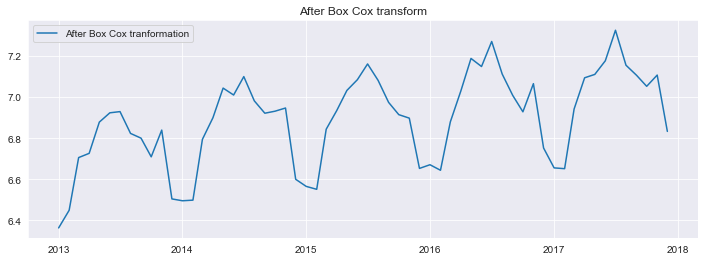

In [121]:
from scipy.stats import boxcox
data_boxcox = pd.Series(boxcox(data1['sales'], lmbda=0), index = data1.index)

plt.figure(figsize=(12,4))
plt.plot(data_boxcox, label='After Box Cox tranformation')
plt.legend(loc='best')
plt.title('After Box Cox transform')
plt.show()

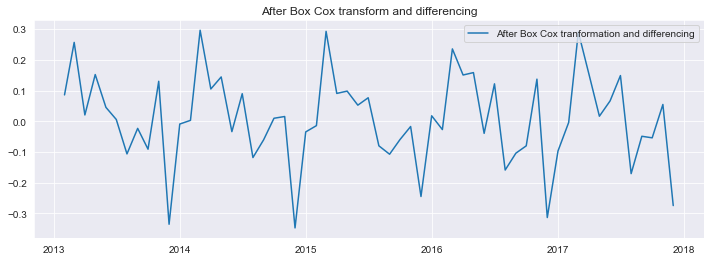

In [122]:
data_boxcox_diff = pd.Series(data_boxcox - data_boxcox.shift(), data1.index)
plt.figure(figsize=(12,4))
plt.plot(data_boxcox_diff, label='After Box Cox tranformation and differencing')
plt.legend(loc='best')
plt.title('After Box Cox transform and differencing')
plt.show()

In [124]:
data_boxcox_diff.dropna(inplace=True)
data_boxcox_diff.tail()


year_month
2017-08-01   -0.170411
2017-09-01   -0.048790
2017-10-01   -0.053885
2017-11-01    0.054704
2017-12-01   -0.274394
Freq: MS, dtype: float64

### Transformed Tests

#### Augmented Dickey-Fuller (ADF) test

In [125]:
adf_test = adfuller(data_boxcox_diff)

print('ADF Statistic: %f' % adf_test[0])
print('Critical Values @ 0.05: %.2f' % adf_test[4]['5%'])
print('p-value: %f' % adf_test[1])

ADF Statistic: -3.909558
Critical Values @ 0.05: -2.93
p-value: 0.001966


#### Kwiatkowski-Phillips-Schmidt-Shin (KPSS) test

In [126]:
kpss_test = kpss(data_boxcox_diff)

print('KPSS Statistic: %f' % kpss_test[0])
print('Critical Values @ 0.05: %.2f' % kpss_test[3]['5%'])
print('p-value: %f' % kpss_test[1])

KPSS Statistic: 0.535472
Critical Values @ 0.05: 0.46
p-value: 0.033677


### Train-Test Split

In [128]:
train_data_boxcox = data_boxcox[:train_len]
test_data_boxcox = data_boxcox[train_len:]
train_data_boxcox_diff = data_boxcox_diff[:train_len-1]
test_data_boxcox_diff = data_boxcox_diff[train_len-1:]

### Auto regression method (AR)


In [129]:
from statsmodels.tsa.arima_model import ARIMA
model = ARIMA(train_data_boxcox_diff, order=(1, 0, 0)) 
model_fit = model.fit()
print(model_fit.params)

const      0.015691
ar.L1.y    0.127342
dtype: float64


In [130]:
y_hat_ar = data_boxcox_diff.copy()
y_hat_ar['ar_forecast_boxcox_diff'] = model_fit.predict(data_boxcox_diff.index.min(), data_boxcox_diff.index.max())
y_hat_ar['ar_forecast_boxcox'] = y_hat_ar['ar_forecast_boxcox_diff'].cumsum()
y_hat_ar['ar_forecast_boxcox'] = y_hat_ar['ar_forecast_boxcox'].add(data_boxcox[0])
y_hat_ar['ar_forecast'] = np.exp(y_hat_ar['ar_forecast_boxcox'])

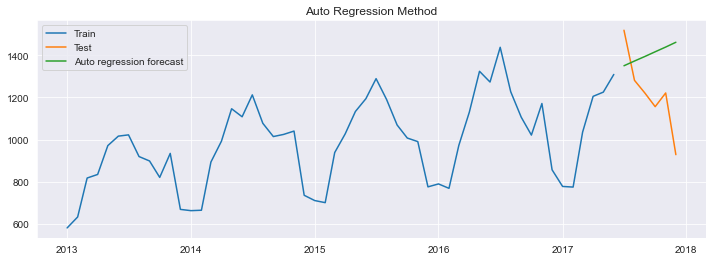

In [131]:
plt.figure(figsize=(12,4))
plt.plot(train['sales'], label='Train')
plt.plot(test['sales'], label='Test')
plt.plot(y_hat_ar['ar_forecast'][test.index.min():], label='Auto regression forecast')
plt.legend(loc='best')
plt.title('Auto Regression Method')
plt.show()

In [132]:
rmse = np.sqrt(mean_squared_error(test['sales'], y_hat_ar['ar_forecast'][test.index.min():])).round(2)
mape = np.round(np.mean(np.abs(test['sales']-y_hat_ar['ar_forecast'][test.index.min():])/test['sales'])*100,2)

tempResults = pd.DataFrame({'Method':['Autoregressive (AR) method'], 'RMSE': [rmse],'MAPE': [mape] })
results = pd.concat([results, tempResults])
results = results[['Method', 'RMSE', 'MAPE']]
results

,Method,RMSE,MAPE
0,Naive method,195.41,14.13
0,Simple average method,294.65,19.71
0,Simple moving average forecast,214.86,14.36
0,Simple exponential smoothing forecast,195.41,14.13
0,Holt's exponential smoothing method,238.50,18.10
0,Holt Winters' additive method,68.99,4.56
0,Holt Winters' multiplicative method,59.51,4.52
0,Autoregressive (AR) method,279.28,21.76


### Moving average method (MA)

In [133]:
model = ARIMA(train_data_boxcox_diff, order=(0, 0, 1)) 
model_fit = model.fit()
print(model_fit.params)

const      0.015527
ma.L1.y    0.088902
dtype: float64


In [134]:
y_hat_ma = data_boxcox_diff.copy()
y_hat_ma['ma_forecast_boxcox_diff'] = model_fit.predict(data_boxcox_diff.index.min(), data_boxcox_diff.index.max())
y_hat_ma['ma_forecast_boxcox'] = y_hat_ma['ma_forecast_boxcox_diff'].cumsum()
y_hat_ma['ma_forecast_boxcox'] = y_hat_ma['ma_forecast_boxcox'].add(data_boxcox[0])
y_hat_ma['ma_forecast'] = np.exp(y_hat_ma['ma_forecast_boxcox'])

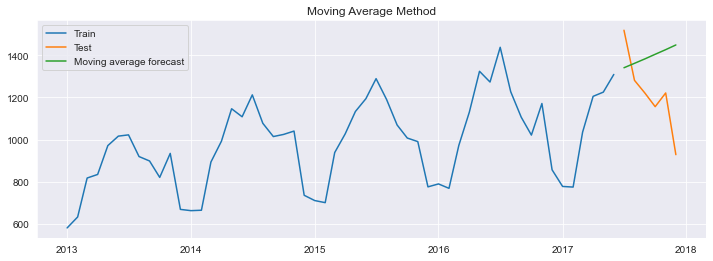

In [135]:
plt.figure(figsize=(12,4))
plt.plot(data1['sales'][:train_len], label='Train')
plt.plot(data1['sales'][train_len:], label='Test')
plt.plot(y_hat_ma['ma_forecast'][test.index.min():], label='Moving average forecast')
plt.legend(loc='best')
plt.title('Moving Average Method')
plt.show()

In [137]:
# Calculate RMSE and MAPE

rmse = np.sqrt(mean_squared_error(test['sales'], y_hat_ma['ma_forecast'][test.index.min():])).round(2)
mape = np.round(np.mean(np.abs(test['sales']-y_hat_ma['ma_forecast'][test.index.min():])/test['sales'])*100,2)

tempResults = pd.DataFrame({'Method':['Moving Average (MA) method'], 'RMSE': [rmse],'MAPE': [mape] })
results = pd.concat([results, tempResults])
results = results[['Method', 'RMSE', 'MAPE']]
results

,Method,RMSE,MAPE
0,Naive method,195.41,14.13
0,Simple average method,294.65,19.71
0,Simple moving average forecast,214.86,14.36
0,Simple exponential smoothing forecast,195.41,14.13
0,Holt's exponential smoothing method,238.50,18.10
0,Holt Winters' additive method,68.99,4.56
0,Holt Winters' multiplicative method,59.51,4.52
0,Autoregressive (AR) method,279.28,21.76
0,Moving Average (MA) method,271.02,20.99


### Auto regression moving average method (ARMA)

In [138]:
model = ARIMA(train_data_boxcox_diff, order=(1, 0, 1))
model_fit = model.fit()
print(model_fit.params)

const      0.016079
ar.L1.y    0.348100
ma.L1.y   -0.210259
dtype: float64


In [139]:
y_hat_arma = data_boxcox_diff.copy()
y_hat_arma['arma_forecast_boxcox_diff'] = model_fit.predict(data_boxcox_diff.index.min(), data_boxcox_diff.index.max())
y_hat_arma['arma_forecast_boxcox'] = y_hat_arma['arma_forecast_boxcox_diff'].cumsum()
y_hat_arma['arma_forecast_boxcox'] = y_hat_arma['arma_forecast_boxcox'].add(data_boxcox[0])
y_hat_arma['arma_forecast'] = np.exp(y_hat_arma['arma_forecast_boxcox'])

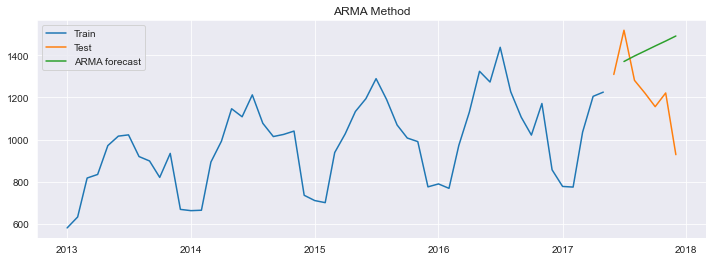

In [140]:
plt.figure(figsize=(12,4))
plt.plot( data1['sales'][:train_len-1], label='Train')
plt.plot(data1['sales'][train_len-1:], label='Test')
plt.plot(y_hat_arma['arma_forecast'][test.index.min():], label='ARMA forecast')
plt.legend(loc='best')
plt.title('ARMA Method')
plt.show()

In [141]:
rmse = np.sqrt(mean_squared_error(test['sales'], y_hat_arma['arma_forecast'][train_len-1:])).round(2)
mape = np.round(np.mean(np.abs(test['sales']-y_hat_arma['arma_forecast'][train_len-1:])/test['sales'])*100,2)

tempResults = pd.DataFrame({'Method':['Autoregressive moving average (ARMA) method'], 'RMSE': [rmse],'MAPE': [mape] })
results = pd.concat([results, tempResults])
results = results[['Method', 'RMSE', 'MAPE']]
results

,Method,RMSE,MAPE
0,Naive method,195.41,14.13
0,Simple average method,294.65,19.71
0,Simple moving average forecast,214.86,14.36
0,Simple exponential smoothing forecast,195.41,14.13
0,Holt's exponential smoothing method,238.50,18.10
0,Holt Winters' additive method,68.99,4.56
0,Holt Winters' multiplicative method,59.51,4.52
0,Autoregressive (AR) method,279.28,21.76
0,Moving Average (MA) method,271.02,20.99
0,Autoregressive moving average (ARMA) method,299.26,23.52


### Auto regressive integrated moving average (ARIMA)


In [142]:
model = ARIMA(train_data_boxcox, order=(1, 1, 1))
model_fit = model.fit()
print(model_fit.params)

const        0.016079
ar.L1.D.y    0.348100
ma.L1.D.y   -0.210259
dtype: float64


In [143]:
y_hat_arima = data_boxcox_diff.copy()
y_hat_arima['arima_forecast_boxcox_diff'] = model_fit.predict(data_boxcox_diff.index.min(), data_boxcox_diff.index.max())
y_hat_arima['arima_forecast_boxcox'] = y_hat_arima['arima_forecast_boxcox_diff'].cumsum()
y_hat_arima['arima_forecast_boxcox'] = y_hat_arima['arima_forecast_boxcox'].add(data_boxcox[0])
y_hat_arima['arima_forecast'] = np.exp(y_hat_arima['arima_forecast_boxcox'])

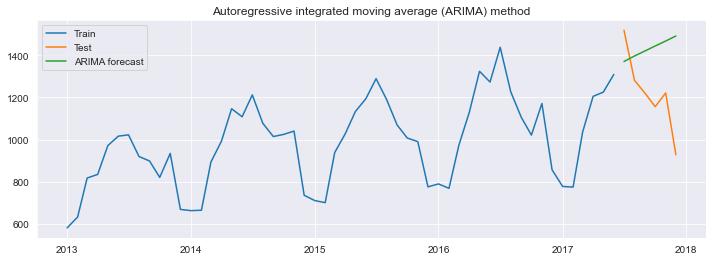

In [144]:
plt.figure(figsize=(12,4))
plt.plot(train['sales'], label='Train')
plt.plot(test['sales'], label='Test')
plt.plot(y_hat_arima['arima_forecast'][test.index.min():], label='ARIMA forecast')
plt.legend(loc='best')
plt.title('Autoregressive integrated moving average (ARIMA) method')
plt.show()

In [146]:
rmse = np.sqrt(mean_squared_error(test['sales'], y_hat_arima['arima_forecast'][test.index.min():])).round(2)
mape = np.round(np.mean(np.abs(test['sales']-y_hat_arima['arima_forecast'][test.index.min():])/test['sales'])*100,2)

tempResults = pd.DataFrame({'Method':['Autoregressive integrated moving average (ARIMA) method'], 'RMSE': [rmse],'MAPE': [mape] })
results = pd.concat([results, tempResults])
results = results[['Method', 'RMSE', 'MAPE']]
results

,Method,RMSE,MAPE
0,Naive method,195.41,14.13
0,Simple average method,294.65,19.71
0,Simple moving average forecast,214.86,14.36
0,Simple exponential smoothing forecast,195.41,14.13
0,Holt's exponential smoothing method,238.50,18.10
0,Holt Winters' additive method,68.99,4.56
0,Holt Winters' multiplicative method,59.51,4.52
0,Autoregressive (AR) method,279.28,21.76
0,Moving Average (MA) method,271.02,20.99
0,Autoregressive moving average (ARMA) method,299.26,23.52


### Seasonal auto regressive integrated moving average (SARIMA)

In [147]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

model = SARIMAX(train_data_boxcox, order=(1, 1, 1), seasonal_order=(1, 1, 1, 12)) 
model_fit = model.fit()
print(model_fit.params)

ar.L1       0.408925
ma.L1      -0.999404
ar.S.L12   -0.444220
ma.S.L12   -0.264559
sigma2      0.002202
dtype: float64


In [148]:
y_hat_sarima = data_boxcox_diff.copy()
y_hat_sarima['sarima_forecast_boxcox'] = model_fit.predict(data_boxcox_diff.index.min(), data_boxcox_diff.index.max())
y_hat_sarima['sarima_forecast'] = np.exp(y_hat_sarima['sarima_forecast_boxcox'])

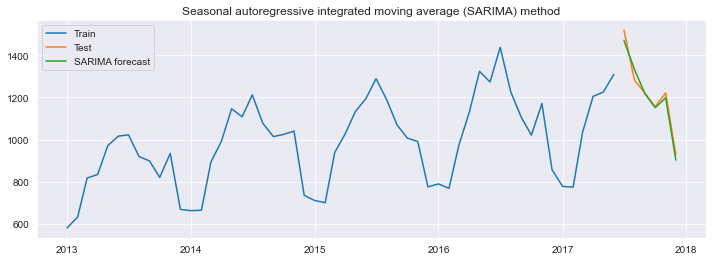

In [150]:
plt.figure(figsize=(12,4))
plt.plot(train['sales'], label='Train')
plt.plot(test['sales'], label='Test')
plt.plot(y_hat_sarima['sarima_forecast'][test.index.min():], label='SARIMA forecast')
plt.legend(loc='best')
plt.title('Seasonal autoregressive integrated moving average (SARIMA) method')
plt.show()

In [151]:
rmse = np.sqrt(mean_squared_error(test['sales'], y_hat_sarima['sarima_forecast'][test.index.min():])).round(2)
mape = np.round(np.mean(np.abs(test['sales']-y_hat_sarima['sarima_forecast'][test.index.min():])/test['sales'])*100,2)

tempResults = pd.DataFrame({'Method':['Seasonal autoregressive integrated moving average (SARIMA) method'], 'RMSE': [rmse],'MAPE': [mape] })
results = pd.concat([results, tempResults])
results = results[['Method', 'RMSE', 'MAPE']]
results

,Method,RMSE,MAPE
0,Naive method,195.41,14.13
0,Simple average method,294.65,19.71
0,Simple moving average forecast,214.86,14.36
0,Simple exponential smoothing forecast,195.41,14.13
0,Holt's exponential smoothing method,238.50,18.10
0,Holt Winters' additive method,68.99,4.56
0,Holt Winters' multiplicative method,59.51,4.52
0,Autoregressive (AR) method,279.28,21.76
0,Moving Average (MA) method,271.02,20.99
0,Autoregressive moving average (ARMA) method,299.26,23.52


# Conclusion

In [158]:
results.sort_values(['RMSE', 'MAPE'], ascending=False)[-3:]

,Method,RMSE,MAPE
0,Holt Winters' additive method,68.99,4.56
0,Holt Winters' multiplicative method,59.51,4.52
0,Seasonal autoregressive integrated moving aver...,32.40,2.11


**SARIMA model is the best one for this type of modeling given that it captured the trends in the data perfectly.**